In [1]:
%load_ext autoreload
%autoreload 2 

In [ ]:
import numpy as np 
import pandas as pd

In [3]:
dataset_path = "./dataset.csv"
full = False

df = pd.read_csv(
    dataset_path,
    # dtype is specified to prevent a DtypeWarning
    dtype={
        "full_query": str,
        "label": int,
        "statement_type": str,
        "query_template_id": str,
        "attack_payload": str,
        "attack_id": str,
        "attack_technique": str,
        "attack_desc": str,
        "split": str,
        "sqlmap_status" : str,
        "attack_stage" : str,
    },
)


/tmp/nix-shell-53297-0/ipykernel_55751/1850950179.py:4: DtypeWarning: Columns (4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(


## Generic stats   


In [4]:
def display_counts_recon(df : pd.DataFrame):
    result = df.groupby('attack_id')['attack_stage'].value_counts().unstack(fill_value=0)
    
    if full:
        with pd.option_context('display.max_rows', None, 
                        'display.max_columns', None,
                        'display.width', None,
                        'display.max_colwidth', None):
            display(result)
    else: 
        display(result)

        
_ = display_counts_recon(df)


attack_stage,exploit,recon
attack_id,,
boolean-0,0,2709
boolean-102,6322,151
boolean-108,8,173
boolean-114,6323,153
boolean-12,0,3078
...,...,...
union-8,0,3430
union-80,0,512
union-86,0,254


In [5]:
def display_attack_normal_per_set(df : pd.DataFrame):
    df_train_atk = df[(df["label"] == 1) & (df["split"] == "train")]  
    df_train_normal = df[(df["label"] == 0) & (df["split"] == "train")]  

    df_test_atk = df[(df["label"] == 1) & (df["split"] == "test")]  
    df_test_normal = df[(df["label"] == 0) & (df["split"] == "test")]  

    print(f"Number of attacks in train: {df_train_atk.shape[0]}")
    print(f"Number of normal in train: {df_train_normal.shape[0]}")
    print(f"Number of attacks in test: {df_test_atk.shape[0]}")
    print(f"Number of normal in test: {df_test_normal.shape[0]}")

display_attack_normal_per_set(df)

Number of attacks in train: 136039
Number of normal in train: 140006
Number of attacks in test: 74510
Number of normal in test: 819120


In [6]:
def display_ids_per_set(df: pd.DataFrame):
    df_train = df[df["split"] == "train"]
    df_test = df[df["split"] == "test"]

    tids_train = df_train["query_template_id"].unique()
    tids_test = df_test["query_template_id"].unique()
    tids_complement = set(tids_test) - set(tids_train)
    print(f"Template IDS in df train: {len(tids_train)}, {tids_train}")
    print(f"Template IDS in df test:   {len(tids_test)}, {tids_test}")
    print(
        f"Template IDs in test but NOT in train: {len(tids_complement)}, {tids_complement}"
    )

    # Compute which template only have normal queries
    df_n = df.loc[df["label"] == 0,"query_template_id"].unique()
    df_a = df.loc[df["label"] == 1,"query_template_id"].unique()

    print(f"Templates IDs with no attacks: {set(df_n) - set(df_a)}")


display_ids_per_set(df)

Template IDS in df train: 44, ['airport-I4' 'airport-S12' 'airport-I8' 'airport-admin12' 'airport-U5'
 'airport-U1' 'airport-U8' 'airport-S14' 'airport-S11' 'airport-S17'
 'airport-I1' 'airport-S4' 'airport-U9' 'airport-I9' 'airport-S9'
 'airport-I2' 'airport-U2' 'airport-S8' 'airport-I3' 'airport-S10'
 'airport-S15' 'airport-D1' 'airport-D2' 'airport-D5' 'airport-D4'
 'airport-S2' 'airport-D7' 'airport-D8' 'airport-S1' 'airport-D6'
 'airport-S5' 'airport-admin6' 'airport-admin9' 'airport-admin10'
 'airport-admin11' 'airport-admin8' 'airport-admin5' 'airport-admin13'
 'airport-admin7' 'airport-admin2' 'airport-admin3' 'airport-admin4'
 'airport-admin14' 'airport-admin1']
Template IDS in df test:   51, ['airport-S15' 'airport-S13' 'airport-S16' 'airport-U9' 'airport-S9'
 'airport-S2' 'airport-I2' 'airport-U2' 'airport-S8' 'airport-S4'
 'airport-S17' 'airport-U1' 'airport-S5' 'airport-I9' 'airport-I4'
 'airport-U4' 'airport-I1' 'airport-U3' 'airport-U8' 'airport-S12'
 'airport-D7' 'airpo

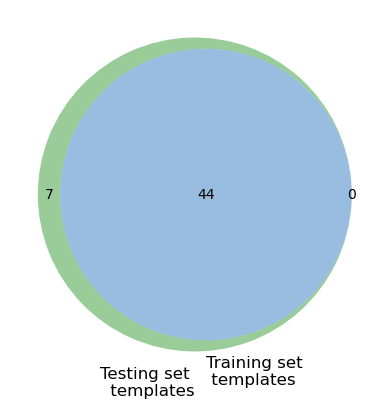

In [22]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn2

def plot_templates_in_sets(df : pd.DataFrame): 
        
    df_train = df[df["split"] == "train"]
    df_test = df[df["split"] == "test"]
    
    tids_train = df_train["query_template_id"].unique()
    tids_test = df_test["query_template_id"].unique()
    venn2((set(tids_test),set(tids_train)), ("Testing set \n templates","Training set \n templates"),set_colors=("green","blue"))
    plt.show()

plot_templates_in_sets(df=df)

In [7]:
def _stmt_proportion(df: pd.DataFrame):
    return df['statement_type'].value_counts(normalize=True)

def display_ratio_per_stmt(df : pd.DataFrame):
    
    df_a = df[df["label"] == 1]
    df_n = df[df["label"] == 0]
    print(f"Proportion amongst normal: {_stmt_proportion(df=df_n)}")
    print(f"Proportion amongst attacks: {_stmt_proportion(df=df_a)}")
        
    df_train = df[df["split"] == "train"]
    df_test = df[df["split"] == "test"]
    print(f"Proportion amongst train: {_stmt_proportion(df=df_train)}")
    print(f"Proportion amongst test: {_stmt_proportion(df=df_test)}")

    dfntest = df_test[df_test["label"] == 0]

display_ratio_per_stmt(df=df)

Proportion amongst normal: statement_type
select    0.699281
delete    0.101661
update    0.098085
insert    0.090580
admin     0.010392
Name: proportion, dtype: float64
Proportion amongst attacks: statement_type
select    0.371101
insert    0.309994
update    0.185957
delete    0.132948
Name: proportion, dtype: float64
Proportion amongst train: statement_type
select    0.529193
insert    0.207046
update    0.139539
delete    0.118187
admin     0.006035
Name: proportion, dtype: float64
Proportion amongst test: statement_type
select    0.674500
insert    0.106300
update    0.105983
delete    0.103928
admin     0.009289
Name: proportion, dtype: float64


In [8]:
# ASR = Attack success rate
def display_asr_per_technique(df : pd.DataFrame):
    df_a = df[df["label"] == 1]
    # First keep a sample for each ID: 
    # dfs = df_a.groupby('attack_id').sample(n=1, random_state=42)
    # # Then, compute for each technique, the success 
    # r = dfs["attack_status"].value_counts(dropna=False)
    # print(r)

display_asr_per_technique(df=df)

In [9]:
def display_NAN_sqlmap_status(df : pd.DataFrame): 
    df_a = df[df["label"] == 1]
    dfa_nan = df_a[df_a["sqlmap_status"].isna()]
    display(dfa_nan)
